# North Carolina Litigation Predictor

# Final Preprocessing and Modeling
### Contents:
<ul>
    <li> Import Libraries
    <li> Final Preprocessing / One-Hot Encoding
    <li> Model Creation
        
</ul>       

## Import Libraries & Data

In [1]:
import io
import pandas as pd
import pickle

import numpy as np
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, RandomizedSearchCV
from collections import defaultdict
from sklearn.metrics import (accuracy_score, classification_report, roc_auc_score,
f1_score, recall_score, precision_score, plot_confusion_matrix, roc_curve, auc)
import xgboost as xgb
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

/Users/joenelson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/Users/joenelson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [34]:
# Open the dataframe
infile = open('ProjectData/df_features.data', 'rb')
df = pickle.load(infile)
infile.close()

## Review and Clean DataFrame of Unneeded Columns

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2634 entries, 0 to 2633
Data columns (total 10 columns):
index                   2634 non-null int64
Opinion                 2634 non-null object
SCT                     2634 non-null int64
Year_Filed              2634 non-null int64
File_Numbers            2634 non-null object
Result                  2634 non-null int64
Case_Type               2634 non-null object
Case_Type_Confidence    2634 non-null object
Trial_Judge             2634 non-null object
County                  2634 non-null object
dtypes: int64(4), object(6)
memory usage: 205.9+ KB


In [36]:
df = df[['Result', 'Case_Type', 'Trial_Judge', 'County']]

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2634 entries, 0 to 2633
Data columns (total 4 columns):
Result         2634 non-null int64
Case_Type      2634 non-null object
Trial_Judge    2634 non-null object
County         2634 non-null object
dtypes: int64(1), object(3)
memory usage: 82.4+ KB


In [38]:
df.tail()

,Result,Case_Type,Trial_Judge,County
2629,1,property,nan,onslow
2630,0,family_law,nan,person
2631,1,contract,nan,union
2632,1,family_law,nan,mecklenburg
2633,1,construction,nan,guilford


## One-Hot Encoding and Train/Test Split

In [39]:
y = df.Result
X = df.drop(columns = ['Result'])

In [40]:
X2 = X[:1]

In [41]:
# Either/Or of the following two:
X_gd = pd.get_dummies(X)
ohe = OneHotEncoder(handle_unknown='ignore')
X_ohe = ohe.fit_transform(X)

In [42]:
ohe.get_feature_names(X.columns)
# X.columns

array(['Case_Type_car_crash', 'Case_Type_construction',
       'Case_Type_contract', 'Case_Type_corporate',
       'Case_Type_defamation', 'Case_Type_employment',
       'Case_Type_estates', 'Case_Type_family_law',
       'Case_Type_fraud_udtpa', 'Case_Type_governmental',
       'Case_Type_insurance', 'Case_Type_landlord_tenant',
       'Case_Type_med_mal', 'Case_Type_other', 'Case_Type_premises',
       'Case_Type_products', 'Case_Type_property',
       'Case_Type_workers_comp', 'Case_Type_wrongful_death',
       'Trial_Judge_abernathy, g', 'Trial_Judge_abernethy, r',
       'Trial_Judge_adams, g', 'Trial_Judge_adkins, k',
       'Trial_Judge_albright, ', 'Trial_Judge_albright, r',
       'Trial_Judge_albright, s', 'Trial_Judge_albright, w',
       'Trial_Judge_aldridge, t', 'Trial_Judge_alexander, k',
       'Trial_Judge_alford, b', 'Trial_Judge_allen, j',
       'Trial_Judge_allen, p', 'Trial_Judge_allen, s',
       'Trial_Judge_allen, w', 'Trial_Judge_allsbrook, r',
       'Trial_J

In [43]:
X_gd.shape, X_ohe.shape

((2634, 561), (2634, 561))

In [44]:
# View class imbalance
y.value_counts()

1    1962
0     672
Name: Result, dtype: int64

### Remember, "affirmed"=1, "reversed"=0

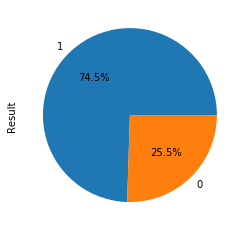

In [45]:
#Visualize class imbalance
y.value_counts().plot.pie(autopct="%.1f%%")

In [46]:
# USING X_ohe - SWITCH OUT IF DESIRED
X_train_unbalanced, X_test, y_train_unbalanced, y_test = train_test_split(X_ohe,y,random_state = 42, test_size = 0.3)

In [47]:
# sm = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=42)
# X_train ,y_train = sm.fit_resample(X_train, y_train) 

indices = [i for i in range(len(X.columns))]
smnc = SMOTENC(categorical_features=indices, random_state=42, sampling_strategy='not majority')
X_train, y_train = smnc.fit_resample(X_train_unbalanced, y_train_unbalanced)

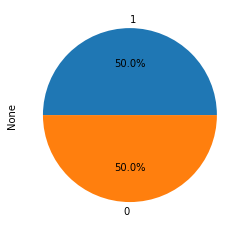

In [48]:
pd.Series(y_train).value_counts().plot.pie(autopct="%.1f%%");

In [49]:
X_train.shape, y_train.shape

((2746, 561), (2746,))

# Modeling

Some research into the best probabilistic classification models suggests that logistic regression, SVMs, and neural networks would be the best fit for the intended goal.  I will run each on the data and see which performs best. 

## Set Baseline with Dummy Classifier

In [50]:
def dummy_classifier(X_train, X_test, y_train, y_test):
    """
    Runs a dummy classifier and prepares a classification report on the train/test
    sets. 
    """
    dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
    dummy_clf.fit(X_train, y_train)
    y_hat = dummy_clf.predict(X_test)
    print('Classification Report:\n', classification_report(y_test, y_hat), '\n',
          plot_confusion_matrix(dummy_clf, X_test, y_test, cmap='GnBu', values_format = '.5g'), 
          plt.show())
    return()

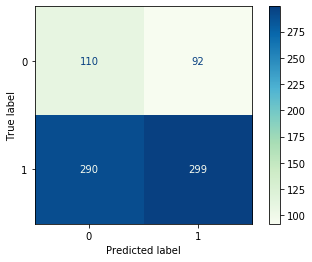

Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.54      0.37       202
           1       0.76      0.51      0.61       589

    accuracy                           0.52       791
   macro avg       0.52      0.53      0.49       791
weighted avg       0.64      0.52      0.55       791
 
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7fe87540d278> None


()

In [51]:
dummy_classifier(X_train_unbalanced, X_test, y_train_unbalanced, y_test)

DUMMY CLASSIFIER sets a baseline for the next few models with a baseline accuracy of .49 and precision of 0.24/0.75 for classes 0/1 respectively.  

## Logistic Regression Model

In [52]:
def logreg_fn(X_train, X_test, y_train, y_test, params):
    """
    Runs a logistic regression a train/test set after running a
    grid search using an input set of parameters, returns the 
    best parameters and a classification report. 
    """
    logreg_clf = LogisticRegression(random_state=12)
    logreg_gs = GridSearchCV(logreg_clf, params, cv=5)
    logreg_gs.fit(X_train, y_train)
    best = logreg_gs.best_params_
    logreg_final = LogisticRegression(solver=best['solver'],
                                      penalty=best['penalty'],
                                      C=best['C'], 
                                      random_state=12)
    logreg_final.fit(X_train, y_train)
    y_hat = logreg_final.predict(X_test)
    print('Best params:',best,
          '\n\nClassification Report:\n', classification_report(y_test, y_hat), '\n',
          plot_confusion_matrix(logreg_final, X_test, y_test, cmap='GnBu', values_format = '.5g'), 
          plt.show())
    return(best)

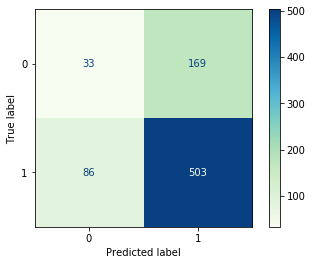

Best params: {'C': 750, 'penalty': 'none', 'solver': 'newton-cg'} 

Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.16      0.21       202
           1       0.75      0.85      0.80       589

    accuracy                           0.68       791
   macro avg       0.51      0.51      0.50       791
weighted avg       0.63      0.68      0.65       791
 
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7fe875b39e80> None


In [53]:
lr_parameters = {'C':[750,500,100], 
              'penalty':['l1', 'l2', 'elasticnet', 'none'],
              'solver':['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}

best_lr=logreg_fn(X_train_unbalanced, X_test, y_train_unbalanced, y_test, lr_parameters)

This model certainly improved over baseline, with accuracy increasing to .68.  However, this is still far from an ideal number. <br>
Same accuracy for unbalanced data (0.62, f1 of .74) (before adjustments to judges and counties)

**Dropped Year_Filed: there's no reason this should be an input, resulted in better performance time-wise, but AUC still is dismal:**<br>
Best params: {'C': 100, 'penalty': 'none', 'solver': 'lbfgs'} <br>
 Accuracy Score - Test:  0.6225 <br>
 Confusion Matrix: <br>
 [[ 59 134]<br>
 [168 439]] <br>
 <br>**Predicted on Trial_Judge and Case_Type:**<br>
 Best params: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'} <br>
 Accuracy Score - Test:  0.62375 <br>
 Confusion Matrix:<br>
 [[ 54 139]<br>
 [162 445]] <br>
 **Predicting on Case_Type Only:**<br>
 Best params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'} <br>
 Accuracy Score - Test:  0.57375 <br>
 Confusion Matrix:<br>
 [[ 74 119]<br>
 [222 385]] <br>
 **Predicting on Trial_Judge Only:**<br>
 Best params: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}  <br>
 Accuracy Score - Test:  0.56375  <br>
 Confusion Matrix: <br>
 [[ 65 128] <br>
 [221 386]]  <br>

## Neural Network -- dropped from final stackingclassifier

In [22]:
from numpy import loadtxt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import keras_metrics as km

Using TensorFlow backend.


In [23]:
tf.random.set_random_seed(7)
model = Sequential()
model.add(Dense(16, input_dim=605, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

W0307 21:24:30.929953 4525055424 module_wrapper.py:139] From /Users/joenelson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0307 21:24:30.931669 4525055424 module_wrapper.py:139] From /Users/joenelson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0307 21:24:30.933835 4525055424 module_wrapper.py:139] From /Users/joenelson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0307 21:24:30.945999 4525055424 module_wrapper.py:139] From /Users/joenelson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_defa

In [24]:
recall = km.binary_recall(label=0)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', recall])

W0307 21:24:31.042223 4525055424 module_wrapper.py:139] From /Users/joenelson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0307 21:24:31.059043 4525055424 module_wrapper.py:139] From /Users/joenelson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0307 21:24:31.063310 4525055424 deprecation.py:323] From /Users/joenelson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0307 21:24:31.090469 4525055424 module_wrapper.py:139] From /Users/joenelson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ke

In [30]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32)

Train on 2208 samples, validate on 552 samples
Epoch 1/100
2208/2208 [==============================] - 0s 70us/step - loss: 0.7018 - acc: 0.8664 - recall: 0.8725 - val_loss: 0.8897 - val_acc: 0.8804 - val_recall: 0.0000e+00
Epoch 2/100
2208/2208 [==============================] - 0s 53us/step - loss: 0.5836 - acc: 0.8555 - recall: 0.8333 - val_loss: 0.6761 - val_acc: 0.9076 - val_recall: 0.0000e+00
Epoch 3/100
2208/2208 [==============================] - 0s 47us/step - loss: 0.4852 - acc: 0.8832 - recall: 0.8710 - val_loss: 0.5853 - val_acc: 0.9167 - val_recall: 0.0000e+00
Epoch 4/100
2208/2208 [==============================] - 0s 45us/step - loss: 0.4533 - acc: 0.8637 - recall: 0.8406 - val_loss: 0.5340 - val_acc: 0.9221 - val_recall: 0.0000e+00
Epoch 5/100
2208/2208 [==============================] - 0s 46us/step - loss: 0.4314 - acc: 0.8655 - recall: 0.8457 - val_loss: 0.4480 - val_acc: 0.9438 - val_recall: 0.0000e+00
Epoch 6/100
2208/2208 [==============================] - 0s 47u

Epoch 92/100
2208/2208 [==============================] - 0s 57us/step - loss: 0.1375 - acc: 0.9452 - recall: 0.9268 - val_loss: 0.1919 - val_acc: 0.9674 - val_recall: 0.0000e+00
Epoch 93/100
2208/2208 [==============================] - 0s 47us/step - loss: 0.1435 - acc: 0.9411 - recall: 0.9210 - val_loss: 0.2293 - val_acc: 0.9656 - val_recall: 0.0000e+00
Epoch 94/100
2208/2208 [==============================] - 0s 45us/step - loss: 0.1501 - acc: 0.9393 - recall: 0.9225 - val_loss: 0.2104 - val_acc: 0.9728 - val_recall: 0.0000e+00
Epoch 95/100
2208/2208 [==============================] - 0s 44us/step - loss: 0.1465 - acc: 0.9429 - recall: 0.9283 - val_loss: 0.1918 - val_acc: 0.9728 - val_recall: 0.0000e+00
Epoch 96/100
2208/2208 [==============================] - 0s 44us/step - loss: 0.1408 - acc: 0.9402 - recall: 0.9261 - val_loss: 0.1990 - val_acc: 0.9710 - val_recall: 0.0000e+00
Epoch 97/100
2208/2208 [==============================] - 0s 45us/step - loss: 0.1429 - acc: 0.9420 - rec

In [31]:
results = model.evaluate(X_test, y_test, batch_size=10)
print('Loss: ', (results[0]),
      '\nAccuracy: ',(results[1]),
      '\nRecall: ',(results[2]))

800/800 [==============================] - 0s 69us/step
Loss:  2.9362806774675847 
Accuracy:  0.6725000038743019 
Recall:  0.8294701985381673


dict_keys(['val_loss', 'val_acc', 'val_recall', 'loss', 'acc', 'recall'])


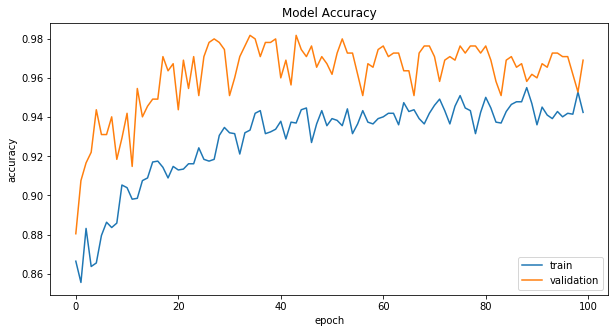

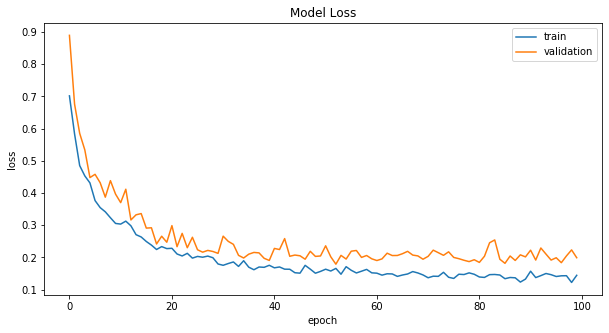

In [32]:
print(history.history.keys())
#  "Accuracy"
plt.figure(figsize=(10,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# "Loss"
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

**Results on Test Set -- last at the bottom **

3 Dense Layers (16/8/1), 100 epochs, 0.2 validation split, batch size 10<br>
Loss:  2.7501846364699305 <br>
Accuracy:  0.6687500029802322 <br>
Recall:  0.8162251654277773<br>
On the loss plot, the loss on the training data remains fairly constant, while the validation loss increases, 


3 Dense Layers (16/8/1) with dropout(0.5) after 2nd Dense, 100 epochs, 0.2 validation split, batch size 20, Changed to unbalanced data: <br>
Loss:  3.7459801264107226 <br>
Accuracy:  0.6387500042095781 <br>
Recall:  0.761589403847419<br>
On the loss plot, both training and validation dropped, but validation climbed thereafter, train continued to decline. 

Above, but add second Dropout after activation layer, change both Dropouts to 0.2:<br>
Loss:  2.2827060595154762 <br>
Accuracy:  0.6775000037625432 <br>
Recall:  0.824503311121771<br>
Loss plot shows initial cross (1st or 2nd epoch) but then smoothly divergent curves. <br><br>
Above, but change batch size to 50:
Loss:  2.543306863121688 <br>
Accuracy:  0.6875000027939677<br> 
Recall:  0.8427152316485571<br>
Loss plot shows to distinct straight-ish lines, with validation slowly increasing but train staying constant. <br>
<br>
Above, but change batch size to 32:<br> 
Loss:  3.0654561286384707 <br>
Accuracy:  0.6887500001117587 <br>
Recall:  0.8493377482037521<br>
Loss plot still very disparate.<br> 
<br>
RETURN to balanced data since both classes matter, increase both dropouts to 0.3, 16/8/1, batch size 32, 100 epochs:<br>**
Loss:  1.8901734507875516 <br>
Accuracy:  0.6712500041350722 <br>
Recall:  0.8261589402605698<br>
Loss plot conjoins! Training/validation accuracy maxes out around 0.9, though test accuracy hasn't really changed.  RE-RAN with 200 epochs, loss begins to diverge at 120; trimmed a little to the final neural net model: 
<br><br>
**--------------------------------------------------------------------------------<br>
RETURN to balanced data since both classes matter, added another hidden layer with a dropout layer, increase all dropouts to 0.3, 16/8/8/1, batch size 32, 100 epochs:<br>**
Loss:  2.6436448619075237 <br>
Accuracy:  0.6862500000745058 <br>
Recall:  0.8476821190649534<br>
<br><br>
Balanced data, loss still diverges: added layers, changed dropouts ... will try to run unbalanced data stacking classifier without nn.

## Random Forest Classifier

In [54]:
def rf_classifier(X_train, X_test, y_train, y_test):
    """
    Takes in train-test-split for X,y;
    Runs a randomized search to tune the hyperparameters, 
    then it runs a random forest on the tuned parameters 
    and returns an Accuracy Score and F1 Score.
    """
    forest_clf = RandomForestClassifier(n_estimators = 110, random_state=42)
    forest_clf.fit(X_train,y_train)
    
    random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
                   'max_features': ['auto', 'sqrt'],
                   'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4],
                   'bootstrap': [True, False]}
    
    rf_random = RandomizedSearchCV(estimator = forest_clf, 
                                   param_distributions = random_grid, 
                                   n_iter = 100, 
                                   cv = 3, 
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs = -1)
    
    rf_random.fit(X_train, y_train)
    best_rf = rf_random.best_params_
    
    rf_final = RandomForestClassifier(n_estimators=best_rf['n_estimators'],
                                      max_features=best_rf['max_features'],
                                      max_depth=best_rf['max_depth'],
                                      min_samples_split=best_rf['min_samples_split'],
                                      min_samples_leaf=best_rf['min_samples_leaf'],
                                      bootstrap=best_rf['bootstrap'])
    
    rf_final.fit(X_train, y_train)
    y_hat = rf_final.predict(X_test)
    print('Best params:',best_rf,
          '\n\nClassification Report:\n', classification_report(y_test, y_hat), '\n',
          plot_confusion_matrix(rf_final, X_test, y_test, cmap='GnBu', values_format = '.5g'), 
          plt.show())
    return(best_rf)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.7min finished


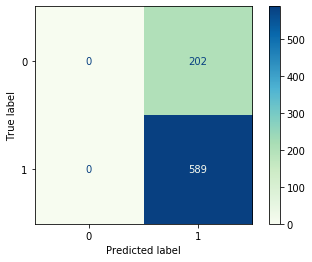

Best params: {'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True} 

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       202
           1       0.74      1.00      0.85       589

    accuracy                           0.74       791
   macro avg       0.37      0.50      0.43       791
weighted avg       0.55      0.74      0.64       791
 
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7fe875b9bf60> None


In [55]:
best_rf=rf_classifier(X_train_unbalanced, X_test, y_train_unbalanced, y_test)

With unbalanced data: accuracy .74, f1 .85<br>
Confusion matrix shows ALL class 0 incorrectly scored and ALL class 1 scored correctly.

## XG Boost Classifier

In [56]:
def xgb_classifier(X_train, X_test, y_train, y_test):
    """
    Takes in train-test-split for X,y;
    Runs RandomizedSearchCV and then uses the 
    best parameters to run an XGB model
    and returns a classification report and the best parameters.
    """
    xgb_clf = xgb.XGBClassifier(random_state=42)
    xgb_clf.fit(X_train, y_train)
    
    random_grid = {'max_depth':[3,5,7,10],
                  'min_child_weight':[1,5,10], 
                  'gamma': [0.0,0.1,0.2,0.4],
                  'colsample_bytree':[0.5, 0.7, 0.9],
                 } 
    
    xgb_random = RandomizedSearchCV(estimator = xgb_clf, 
                                    param_distributions = random_grid, 
                                    n_iter = 100, 
                                    cv = 5,
                                    verbose = 2, 
                                    random_state = 42)
    
    xgb_random.fit(X_train, y_train)
    best_xgb = xgb_random.best_params_
    xgb_final = xgb.XGBClassifier(max_depth=best_xgb['max_depth'], 
                                  min_child_weight=best_xgb['min_child_weight'], 
                                  gamma=best_xgb['gamma'],
                                  colsample_bytree=best_xgb['colsample_bytree'],
                                  random_state=42)
    
    xgb_final.fit(X_train, y_train)
    y_hat = xgb_final.predict(X_test)
    print('XGB best params:',best_xgb,
          '\n\nClassification Report:\n', classification_report(y_test, y_hat), '\n',
          plot_confusion_matrix(xgb_final, X_test, y_test, cmap='GnBu', values_format = '.5g'), 
          plt.show())
    return(best_xgb)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] min_child_weight=1, max_depth=10, gamma=0.1, colsample_bytree=0.9 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_child_weight=1, max_depth=10, gamma=0.1, colsample_bytree=0.9, total=   0.5s
[CV] min_child_weight=1, max_depth=10, gamma=0.1, colsample_bytree=0.9 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  min_child_weight=1, max_depth=10, gamma=0.1, colsample_bytree=0.9, total=   0.5s
[CV] min_child_weight=1, max_depth=10, gamma=0.1, colsample_bytree=0.9 
[CV]  min_child_weight=1, max_depth=10, gamma=0.1, colsample_bytree=0.9, total=   0.5s
[CV] min_child_weight=1, max_depth=10, gamma=0.1, colsample_bytree=0.9 
[CV]  min_child_weight=1, max_depth=10, gamma=0.1, colsample_bytree=0.9, total=   0.5s
[CV] min_child_weight=1, max_depth=10, gamma=0.1, colsample_bytree=0.9 
[CV]  min_child_weight=1, max_depth=10, gamma=0.1, colsample_bytree=0.9, total=   0.5s
[CV] min_child_weight=5, max_depth=7, gamma=0.1, colsample_bytree=0.5 
[CV]  min_child_weight=5, max_depth=7, gamma=0.1, colsample_bytree=0.5, total=   0.2s
[CV] min_child_weight=5, max_depth=7, gamma=0.1, colsample_bytree=0.5 
[CV]  min_child_weight=5, max_depth=7, gamma=0.1, colsample_bytree=0.5, total=   0.2s
[CV] min_child_weight=5, max_depth=7, gamma=0.1, colsample_bytree=0.5 
[CV]  min_child_weight=5, max_depth=7, gamma=0.1, c

[CV]  min_child_weight=1, max_depth=5, gamma=0.0, colsample_bytree=0.7, total=   0.2s
[CV] min_child_weight=1, max_depth=5, gamma=0.0, colsample_bytree=0.7 
[CV]  min_child_weight=1, max_depth=5, gamma=0.0, colsample_bytree=0.7, total=   0.2s
[CV] min_child_weight=1, max_depth=7, gamma=0.2, colsample_bytree=0.7 
[CV]  min_child_weight=1, max_depth=7, gamma=0.2, colsample_bytree=0.7, total=   0.3s
[CV] min_child_weight=1, max_depth=7, gamma=0.2, colsample_bytree=0.7 
[CV]  min_child_weight=1, max_depth=7, gamma=0.2, colsample_bytree=0.7, total=   0.3s
[CV] min_child_weight=1, max_depth=7, gamma=0.2, colsample_bytree=0.7 
[CV]  min_child_weight=1, max_depth=7, gamma=0.2, colsample_bytree=0.7, total=   0.3s
[CV] min_child_weight=1, max_depth=7, gamma=0.2, colsample_bytree=0.7 
[CV]  min_child_weight=1, max_depth=7, gamma=0.2, colsample_bytree=0.7, total=   0.3s
[CV] min_child_weight=1, max_depth=7, gamma=0.2, colsample_bytree=0.7 
[CV]  min_child_weight=1, max_depth=7, gamma=0.2, colsampl

[CV]  min_child_weight=10, max_depth=10, gamma=0.1, colsample_bytree=0.9, total=   0.5s
[CV] min_child_weight=10, max_depth=10, gamma=0.1, colsample_bytree=0.9 
[CV]  min_child_weight=10, max_depth=10, gamma=0.1, colsample_bytree=0.9, total=   0.5s
[CV] min_child_weight=10, max_depth=10, gamma=0.1, colsample_bytree=0.9 
[CV]  min_child_weight=10, max_depth=10, gamma=0.1, colsample_bytree=0.9, total=   0.5s
[CV] min_child_weight=10, max_depth=10, gamma=0.1, colsample_bytree=0.9 
[CV]  min_child_weight=10, max_depth=10, gamma=0.1, colsample_bytree=0.9, total=   0.5s
[CV] min_child_weight=10, max_depth=10, gamma=0.1, colsample_bytree=0.9 
[CV]  min_child_weight=10, max_depth=10, gamma=0.1, colsample_bytree=0.9, total=   0.5s
[CV] min_child_weight=10, max_depth=3, gamma=0.1, colsample_bytree=0.9 
[CV]  min_child_weight=10, max_depth=3, gamma=0.1, colsample_bytree=0.9, total=   0.2s
[CV] min_child_weight=10, max_depth=3, gamma=0.1, colsample_bytree=0.9 
[CV]  min_child_weight=10, max_depth=

[CV]  min_child_weight=10, max_depth=3, gamma=0.0, colsample_bytree=0.9, total=   0.2s
[CV] min_child_weight=10, max_depth=3, gamma=0.0, colsample_bytree=0.9 
[CV]  min_child_weight=10, max_depth=3, gamma=0.0, colsample_bytree=0.9, total=   0.2s
[CV] min_child_weight=1, max_depth=3, gamma=0.4, colsample_bytree=0.5 
[CV]  min_child_weight=1, max_depth=3, gamma=0.4, colsample_bytree=0.5, total=   0.1s
[CV] min_child_weight=1, max_depth=3, gamma=0.4, colsample_bytree=0.5 
[CV]  min_child_weight=1, max_depth=3, gamma=0.4, colsample_bytree=0.5, total=   0.1s
[CV] min_child_weight=1, max_depth=3, gamma=0.4, colsample_bytree=0.5 
[CV]  min_child_weight=1, max_depth=3, gamma=0.4, colsample_bytree=0.5, total=   0.1s
[CV] min_child_weight=1, max_depth=3, gamma=0.4, colsample_bytree=0.5 
[CV]  min_child_weight=1, max_depth=3, gamma=0.4, colsample_bytree=0.5, total=   0.1s
[CV] min_child_weight=1, max_depth=3, gamma=0.4, colsample_bytree=0.5 
[CV]  min_child_weight=1, max_depth=3, gamma=0.4, colsa

[CV]  min_child_weight=1, max_depth=3, gamma=0.0, colsample_bytree=0.5, total=   0.1s
[CV] min_child_weight=1, max_depth=3, gamma=0.0, colsample_bytree=0.5 
[CV]  min_child_weight=1, max_depth=3, gamma=0.0, colsample_bytree=0.5, total=   0.1s
[CV] min_child_weight=1, max_depth=3, gamma=0.0, colsample_bytree=0.5 
[CV]  min_child_weight=1, max_depth=3, gamma=0.0, colsample_bytree=0.5, total=   0.1s
[CV] min_child_weight=1, max_depth=3, gamma=0.0, colsample_bytree=0.5 
[CV]  min_child_weight=1, max_depth=3, gamma=0.0, colsample_bytree=0.5, total=   0.1s
[CV] min_child_weight=1, max_depth=3, gamma=0.4, colsample_bytree=0.7 
[CV]  min_child_weight=1, max_depth=3, gamma=0.4, colsample_bytree=0.7, total=   0.2s
[CV] min_child_weight=1, max_depth=3, gamma=0.4, colsample_bytree=0.7 
[CV]  min_child_weight=1, max_depth=3, gamma=0.4, colsample_bytree=0.7, total=   0.2s
[CV] min_child_weight=1, max_depth=3, gamma=0.4, colsample_bytree=0.7 
[CV]  min_child_weight=1, max_depth=3, gamma=0.4, colsampl

[CV]  min_child_weight=10, max_depth=7, gamma=0.4, colsample_bytree=0.5, total=   0.2s
[CV] min_child_weight=10, max_depth=7, gamma=0.4, colsample_bytree=0.5 
[CV]  min_child_weight=10, max_depth=7, gamma=0.4, colsample_bytree=0.5, total=   0.2s
[CV] min_child_weight=1, max_depth=5, gamma=0.1, colsample_bytree=0.5 
[CV]  min_child_weight=1, max_depth=5, gamma=0.1, colsample_bytree=0.5, total=   0.2s
[CV] min_child_weight=1, max_depth=5, gamma=0.1, colsample_bytree=0.5 
[CV]  min_child_weight=1, max_depth=5, gamma=0.1, colsample_bytree=0.5, total=   0.2s
[CV] min_child_weight=1, max_depth=5, gamma=0.1, colsample_bytree=0.5 
[CV]  min_child_weight=1, max_depth=5, gamma=0.1, colsample_bytree=0.5, total=   0.2s
[CV] min_child_weight=1, max_depth=5, gamma=0.1, colsample_bytree=0.5 
[CV]  min_child_weight=1, max_depth=5, gamma=0.1, colsample_bytree=0.5, total=   0.2s
[CV] min_child_weight=1, max_depth=5, gamma=0.1, colsample_bytree=0.5 
[CV]  min_child_weight=1, max_depth=5, gamma=0.1, colsa

[CV]  min_child_weight=5, max_depth=5, gamma=0.2, colsample_bytree=0.7, total=   0.2s
[CV] min_child_weight=5, max_depth=5, gamma=0.2, colsample_bytree=0.7 
[CV]  min_child_weight=5, max_depth=5, gamma=0.2, colsample_bytree=0.7, total=   0.2s
[CV] min_child_weight=5, max_depth=5, gamma=0.2, colsample_bytree=0.7 
[CV]  min_child_weight=5, max_depth=5, gamma=0.2, colsample_bytree=0.7, total=   0.2s
[CV] min_child_weight=5, max_depth=5, gamma=0.2, colsample_bytree=0.7 
[CV]  min_child_weight=5, max_depth=5, gamma=0.2, colsample_bytree=0.7, total=   0.2s
[CV] min_child_weight=5, max_depth=5, gamma=0.2, colsample_bytree=0.7 
[CV]  min_child_weight=5, max_depth=5, gamma=0.2, colsample_bytree=0.7, total=   0.2s
[CV] min_child_weight=10, max_depth=5, gamma=0.4, colsample_bytree=0.9 
[CV]  min_child_weight=10, max_depth=5, gamma=0.4, colsample_bytree=0.9, total=   0.3s
[CV] min_child_weight=10, max_depth=5, gamma=0.4, colsample_bytree=0.9 
[CV]  min_child_weight=10, max_depth=5, gamma=0.4, cols

[CV]  min_child_weight=5, max_depth=3, gamma=0.4, colsample_bytree=0.7, total=   0.1s
[CV] min_child_weight=5, max_depth=3, gamma=0.4, colsample_bytree=0.7 
[CV]  min_child_weight=5, max_depth=3, gamma=0.4, colsample_bytree=0.7, total=   0.1s
[CV] min_child_weight=5, max_depth=3, gamma=0.4, colsample_bytree=0.7 
[CV]  min_child_weight=5, max_depth=3, gamma=0.4, colsample_bytree=0.7, total=   0.1s
[CV] min_child_weight=5, max_depth=3, gamma=0.1, colsample_bytree=0.9 
[CV]  min_child_weight=5, max_depth=3, gamma=0.1, colsample_bytree=0.9, total=   0.2s
[CV] min_child_weight=5, max_depth=3, gamma=0.1, colsample_bytree=0.9 
[CV]  min_child_weight=5, max_depth=3, gamma=0.1, colsample_bytree=0.9, total=   0.2s
[CV] min_child_weight=5, max_depth=3, gamma=0.1, colsample_bytree=0.9 
[CV]  min_child_weight=5, max_depth=3, gamma=0.1, colsample_bytree=0.9, total=   0.2s
[CV] min_child_weight=5, max_depth=3, gamma=0.1, colsample_bytree=0.9 
[CV]  min_child_weight=5, max_depth=3, gamma=0.1, colsampl

[CV]  min_child_weight=10, max_depth=5, gamma=0.4, colsample_bytree=0.7, total=   0.2s
[CV] min_child_weight=10, max_depth=10, gamma=0.2, colsample_bytree=0.7 
[CV]  min_child_weight=10, max_depth=10, gamma=0.2, colsample_bytree=0.7, total=   0.4s
[CV] min_child_weight=10, max_depth=10, gamma=0.2, colsample_bytree=0.7 
[CV]  min_child_weight=10, max_depth=10, gamma=0.2, colsample_bytree=0.7, total=   0.4s
[CV] min_child_weight=10, max_depth=10, gamma=0.2, colsample_bytree=0.7 
[CV]  min_child_weight=10, max_depth=10, gamma=0.2, colsample_bytree=0.7, total=   0.4s
[CV] min_child_weight=10, max_depth=10, gamma=0.2, colsample_bytree=0.7 
[CV]  min_child_weight=10, max_depth=10, gamma=0.2, colsample_bytree=0.7, total=   0.4s
[CV] min_child_weight=10, max_depth=10, gamma=0.2, colsample_bytree=0.7 
[CV]  min_child_weight=10, max_depth=10, gamma=0.2, colsample_bytree=0.7, total=   0.3s
[CV] min_child_weight=1, max_depth=5, gamma=0.2, colsample_bytree=0.9 
[CV]  min_child_weight=1, max_depth=5

[CV]  min_child_weight=1, max_depth=3, gamma=0.2, colsample_bytree=0.7, total=   0.2s
[CV] min_child_weight=1, max_depth=3, gamma=0.2, colsample_bytree=0.7 
[CV]  min_child_weight=1, max_depth=3, gamma=0.2, colsample_bytree=0.7, total=   0.1s
[CV] min_child_weight=1, max_depth=3, gamma=0.2, colsample_bytree=0.7 
[CV]  min_child_weight=1, max_depth=3, gamma=0.2, colsample_bytree=0.7, total=   0.1s
[CV] min_child_weight=1, max_depth=3, gamma=0.2, colsample_bytree=0.9 
[CV]  min_child_weight=1, max_depth=3, gamma=0.2, colsample_bytree=0.9, total=   0.2s
[CV] min_child_weight=1, max_depth=3, gamma=0.2, colsample_bytree=0.9 
[CV]  min_child_weight=1, max_depth=3, gamma=0.2, colsample_bytree=0.9, total=   0.2s
[CV] min_child_weight=1, max_depth=3, gamma=0.2, colsample_bytree=0.9 
[CV]  min_child_weight=1, max_depth=3, gamma=0.2, colsample_bytree=0.9, total=   0.2s
[CV] min_child_weight=1, max_depth=3, gamma=0.2, colsample_bytree=0.9 
[CV]  min_child_weight=1, max_depth=3, gamma=0.2, colsampl

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.1min finished


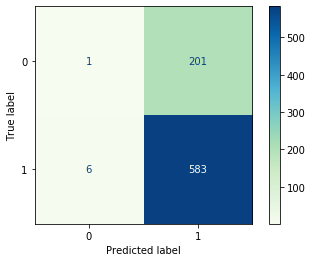

XGB best params: {'min_child_weight': 5, 'max_depth': 7, 'gamma': 0.1, 'colsample_bytree': 0.5} 

Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.00      0.01       202
           1       0.74      0.99      0.85       589

    accuracy                           0.74       791
   macro avg       0.44      0.50      0.43       791
weighted avg       0.59      0.74      0.63       791
 
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7fe88a420668> None


In [57]:
best_xgb=xgb_classifier(X_train_unbalanced, X_test, y_train_unbalanced, y_test)

XG Boost returned an accuracy of 74% and f1-score for class 1 of .85. BUT, the confidence matrix shows that it's predicting most all of the class 1 labels correctly, but most all of the class 0 labels incorrectly. 

<br>Will re-try on the unbalanced data: 
<br> Accuracy of 74% and f1 for class 1 of .85 with unbalanced data. 

# Create Stacked Model

https://towardsdatascience.com/a-practical-guide-to-stacking-using-scikit-learn-91e8d021863d

In [58]:
## Neural net was removed from the final classifier for negative effect on accuracy/f1
# def nn_classifier():
#     """Neural network reformed for scikit-learn"""
#     tf.random.set_random_seed(7)
#     model = Sequential()
#     model.add(Dense(16, input_dim=605, activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(Dense(8, activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(Dense(8, activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(Dense(1, activation='sigmoid'))
#     recall = km.binary_recall(label=0)
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', recall])
#     return model

In [59]:
# NN_clf=KerasClassifier(build_fn=nn_classifier, epochs=100, batch_size= 32, validation_split=0.2)
# NN_clf._estimator_type = "classifier"
# Above removed from final model

LR_clf=LogisticRegression(solver=best_lr['solver'],
                          penalty=best_lr['penalty'],
                          C=best_lr['C'], 
                          random_state=42)

RF_clf=RandomForestClassifier(n_estimators=best_rf['n_estimators'],
                              max_features=best_rf['max_features'],
                              max_depth=best_rf['max_depth'],
                              min_samples_split=best_rf['min_samples_split'],
                              min_samples_leaf=best_rf['min_samples_leaf'],
                              bootstrap=best_rf['bootstrap'], 
                              random_state=42)

XG_clf=xgb.XGBClassifier(max_depth=best_xgb['max_depth'], 
                         min_child_weight=best_xgb['min_child_weight'], 
                         gamma=best_xgb['gamma'],
                         colsample_bytree=best_xgb['colsample_bytree'],
                         random_state=42)
    
estimators = [('LR', LR_clf),  ('RF', RF_clf), ('XG', XG_clf)] # removed ('NN', NN_clf),

clf=StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

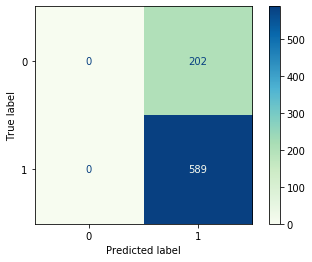

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       202
           1       0.74      1.00      0.85       589

    accuracy                           0.74       791
   macro avg       0.37      0.50      0.43       791
weighted avg       0.55      0.74      0.64       791
 
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7fe875b9bf28> None


In [60]:
clf.fit(X_train_unbalanced, y_train_unbalanced)
y_hat_stacked = clf.predict(X_test)
print('Classification Report:\n', classification_report(y_test, y_hat_stacked),'\n',
      plot_confusion_matrix(clf, X_test, y_test, cmap='GnBu', values_format = '.5g'), 
      plt.show())

**Balanced Data // Scores are Mean Accuracy:**<br>
Stacking model score: 0.714 - no tuning the RF classifier <br>
Stacking model score: 0.719 - tuned RF classifier <br>
Stacking model score: 0.715 - added XGBoost classifier <br>
---- After adding Classification Report:<br>
**1. Balanced Data / Dummy Classifier:**<br>
Accuracy 0.49, f1 0.59 for Class 1 <br>
**2. Balanced Data / Stacking Classifier:**<br>
Accuracy 0.73, f1 0.84 for Class 1 <br>
**3. Unbalanced Data / Dummy Classifier:**<br>
Accuracy 0.49, f1 0.59 for Class 1 <br>
**4. Unbalanced Data / Stacking Classifier -- removed NN since loss diverged: - BEST MODEL**<br>
Accuracy 0.74, f1 0.85 for Class 1 <br>
Results are much better with both unbalanced data and no neural network; should try with balanced and no NN. <br>
**5. Balanced Data / Stacking Classifier -- removed NN as above:**<br>
Accuracy 0.781, f1 0.83 for Class 1 -- WORSE performance than No. 4 (unbalanced/no NN), but better than No. 2 (balanced/incl. NN).  <br>
<br>
**No. 4 appears to be the best performing classifier.**



# Make Test Predictions and Visualizations with Final Model

In [63]:
test_probabilities = clf.predict_proba(X_test)
test_probabilities[:5]

array([[0.25769888, 0.74230112],
       [0.26112867, 0.73887133],
       [0.25579514, 0.74420486],
       [0.24564942, 0.75435058],
       [0.26244311, 0.73755689]])

In [64]:
class_one_probablities = [i[1] for i in test_probabilities]

In [65]:
def scaler(list_, element):
    minx = min(list_)
    maxx = max(list_)
    diff = maxx-minx
    return((element-minx)/diff)

In [66]:
scaled_class_one_probs = [scaler(class_one_probablities,i) for i in class_one_probablities]

In [67]:
sample_proba = clf.predict_proba(X_test[42]).tolist()[0]
sample_proba = round(sample_proba[1],4)
scaled_sample = round(scaler(class_one_probablities, sample_proba),4)
sample_proba, scaled_sample

(0.7347, 0.4923)

In [68]:
def distribution_plot(list_of_probabilities, sample_probability):
    """
    Creates a distribution plot/histogram from a list of probabilities, as well 
    as the mean as a vertical red line and the predicted probability (the "sample
    probability") as a vertical green line. 
    """
    plt.figure(figsize=(10,8))
    sns.distplot(list_of_probabilities, color = 'b', hist=False)
    avg_prob = round(np.average(list_of_probabilities),4)
    plt.axvline(avg_prob, color = 'r')
    plt.axvline(sample_probability, color = 'g')
    plt.title("Distribution of Probabilities of Summary Judgment Being Affirmed\n", fontsize=18)
    plt.legend(["Average Probability: "+str(avg_prob), "Sample Prediction of Test Row x: "+str(sample_probability)], 
               loc='upper left')
    perc_change = round((sample_proba-avg_prob)/avg_prob*100,3)
    plt.show()

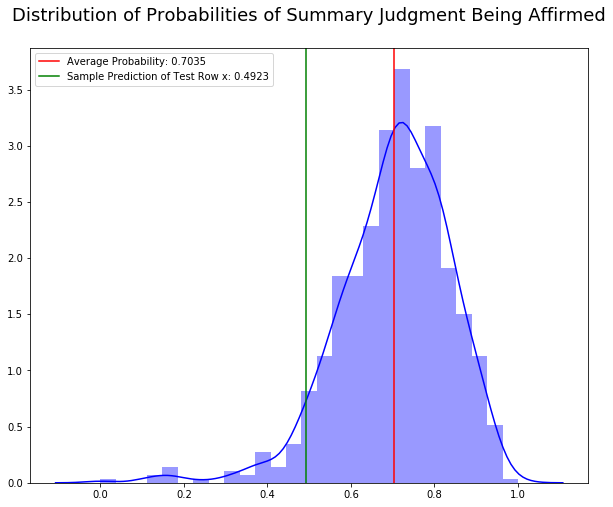

In [69]:
distribution_plot(scaled_class_one_probs, scaled_sample)

In [70]:
avg_success = np.average(scaled_class_one_probs)
difference = round(((scaled_sample-avg_success)/avg_success)*100,2)
print("Given the trial judge, county, and case type, your motion has a "+str(difference)+"% greater/worse chance of being affirmed.")

Given the trial judge, county, and case type, your motion has a -30.02% greater/worse chance of being affirmed.


# Export Model and Lists to Streamlit

In [71]:
# Save the trained model to a data file
with open('ProjectData/final_model.data', 'wb') as filehandle:
    pickle.dump(clf, filehandle)   

In [72]:
list_case_type = sorted(list(set(list(df.Case_Type))))
list_trial_judge = sorted(list(set(list(df.Trial_Judge))))
list_county = sorted(list(set(list(df.County))))
export_lists = [list_case_type, list_trial_judge, list_county, scaled_class_one_probs, class_one_probablities]

In [73]:
# Save selection and probability lists to a data file
with open('ProjectData/strmlit_lists.data', 'wb') as filehandle:
    pickle.dump(export_lists, filehandle)

In [74]:
X2 = X[:1]
X3 = ohe.transform(X2)
pred = round(clf.predict_proba(X3).tolist()[0][1],4)
scaled_pred = round(scaler(class_one_probablities,pred),4)
pred, scaled_pred

(0.748, 0.7681)

In [75]:
# Save fit ohe to transform selections to a data file
with open('ProjectData/fit_ohe.data', 'wb') as filehandle:
    pickle.dump(ohe, filehandle)

In [76]:
# Save one-row sample df to a data file
with open('ProjectData/sample_df.data', 'wb') as filehandle:
    pickle.dump(X2, filehandle)